In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import chi2
import Regression
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.5f}'.format

In [2]:
claim_history = pd.read_excel('claim_history.xlsx')
claim_history.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,TIF,CAR_TYPE,RED_CAR,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,CLM_AMT,CLM_COUNT,EXPOSURE
0,63581743,0,1939-03-16,60.00000,0,11.00000,67000.00000,No,NaN,No,...,11,Minivan,yes,No,3,18.00000,Highly Urban/ Urban,0,0,0.18900
1,132761049,0,1956-01-21,43.00000,0,11.00000,91000.00000,No,257000.00000,No,...,1,Minivan,yes,No,0,1.00000,Highly Urban/ Urban,0,0,1.00000
2,921317019,0,1951-11-18,48.00000,0,11.00000,53000.00000,No,NaN,No,...,1,Van,yes,No,2,10.00000,Highly Urban/ Urban,0,0,1.00000
3,727598473,0,1964-03-05,35.00000,1,10.00000,16000.00000,No,124000.00000,Yes,...,4,SUV,no,No,3,10.00000,Highly Urban/ Urban,0,0,0.82800
4,450221861,0,1948-06-05,51.00000,0,14.00000,NaN,No,306000.00000,Yes,...,7,Minivan,yes,No,0,6.00000,Highly Urban/ Urban,0,0,0.72900


In [3]:
claim_history.columns

Index(['ID', 'KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY', 'CLM_AMT', 'CLM_COUNT',
       'EXPOSURE'],
      dtype='object')

In [4]:
claim_history['SEVERITY'] = [clm_amt/clm_cnt if clm_cnt > 0 else np.nan for clm_amt, clm_cnt in zip(claim_history['CLM_AMT'], claim_history['CLM_COUNT'])]

In [5]:
claim_history.shape

(10302, 27)

In [6]:
target = 'SEVERITY'
cat_pred = ['CAR_TYPE', 'CAR_USE', 'EDUCATION', 'GENDER', 'MSTATUS', 'PARENT1', 'RED_CAR', 'REVOKED', 'URBANICITY']
int_pred = ['AGE', 'BLUEBOOK', 'CAR_AGE', 'HOME_VAL', 'HOMEKIDS', 'INCOME', 'YOJ', 'KIDSDRIV', 'MVR_PTS', 'TIF', 'TRAVTIME']

train_data = claim_history[[target] + cat_pred + int_pred]

for x in ['BLUEBOOK', 'HOME_VAL', 'INCOME']:
    train_data[x] = train_data[x]/1000

train_data = train_data.dropna().reset_index(drop=True) 
train_data.head()

train_data_copy = claim_history[[target] + cat_pred + int_pred + ['CLM_COUNT', 'CLM_AMT', 'EXPOSURE']]
train_data_copy = train_data_copy.dropna().reset_index(drop=True) 

In [7]:
train_data.shape

(1274, 21)

In [8]:
print(train_data.isnull().sum())

SEVERITY      0
CAR_TYPE      0
CAR_USE       0
EDUCATION     0
GENDER        0
MSTATUS       0
PARENT1       0
RED_CAR       0
REVOKED       0
URBANICITY    0
AGE           0
BLUEBOOK      0
CAR_AGE       0
HOME_VAL      0
HOMEKIDS      0
INCOME        0
YOJ           0
KIDSDRIV      0
MVR_PTS       0
TIF           0
TRAVTIME      0
dtype: int64


## QUESTION 1

### We will first establish a baseline model for reference. To that end, we will train the Intercept-only model. This model does not include any predictors except for the Intercept term.

<b>a) (10 points). Please generate a histogram and a horizontal boxplot to show the distribution of Severity. For the histogram, use a bin-width of $500 and put the number of policies on the vertical axis. Put the two graphs in the same chart where the histogram is above the boxplot.

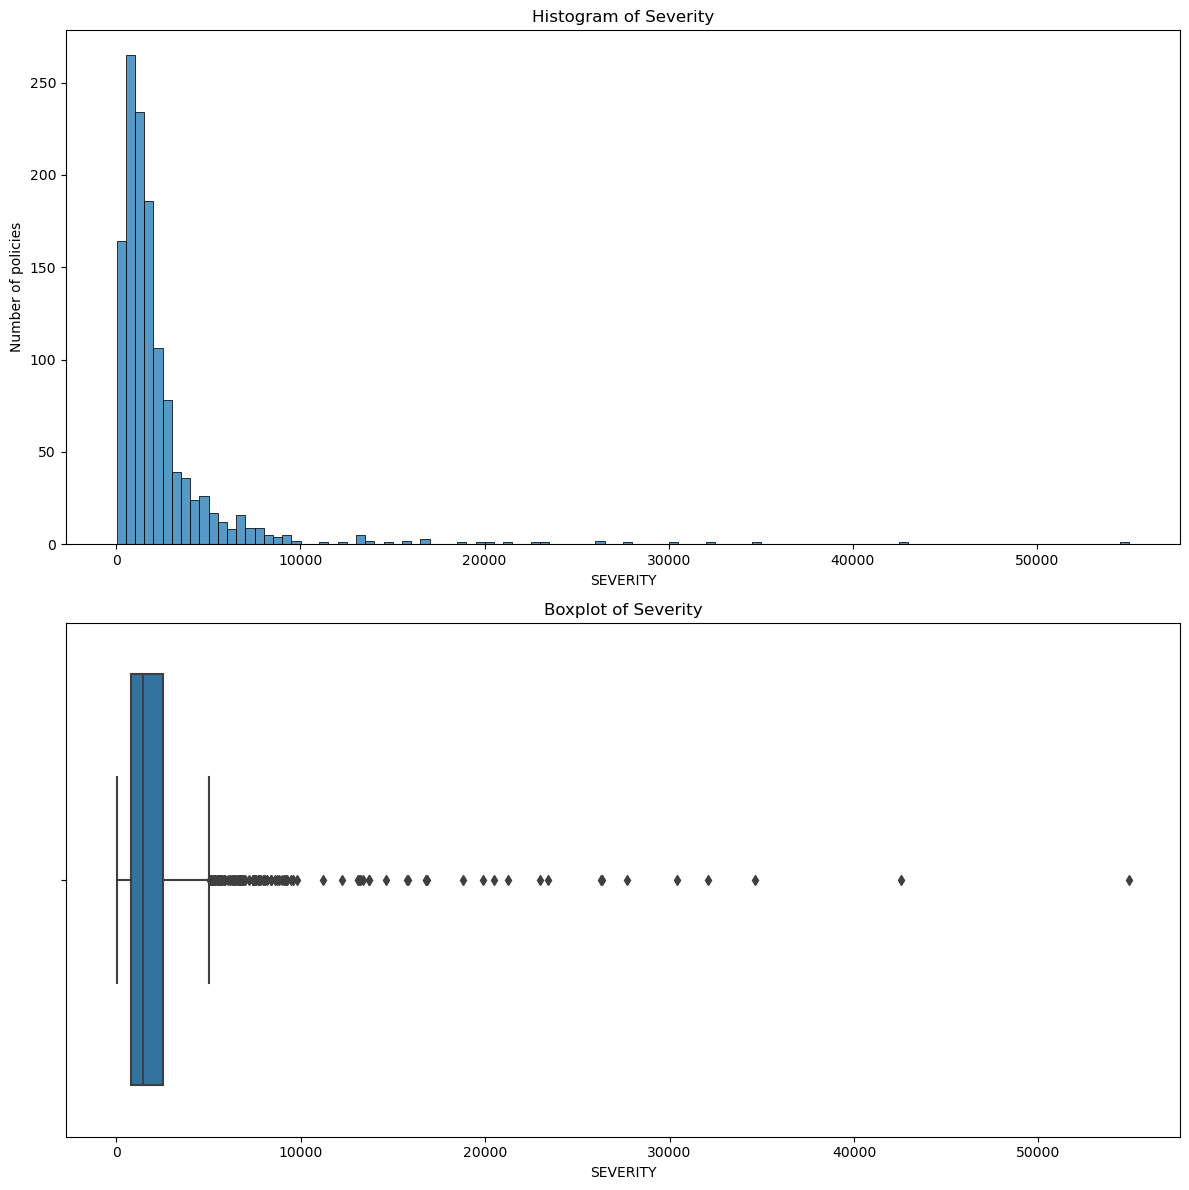

In [9]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# create a histogram of severity
sns.histplot(x='SEVERITY', data=train_data_copy, binwidth=500, ax=ax1)
ax1.set(ylabel = 'Number of policies')

# create a boxplot of severity
sns.boxplot(x='SEVERITY', data=train_data_copy, ax=ax2, orient='h')


# set titles for subplots
ax1.set_title('Histogram of Severity')
ax2.set_title('Boxplot of Severity')

# adjust spacing between subplots
fig.tight_layout()

# show the plot
plt.show()

<b>b) (10 points). What is the log-likelihood value, the Akaike Information Criterion (AIC) value, and the Bayesian Information Criterion (BIC) value of the Intercept-only model?

In [10]:
y_train = train_data[target]

#Intercept-only model
X_train = train_data[[target]]
X_train.insert(0, 'Intercept', 1.0)
X_train = X_train.drop(columns = target)

step_summary = []

result_intercept = Regression.GammaRegression (X_train, y_train)

llk = result_intercept[3]
nonAliasParam = result_intercept[4]

print("The log-likelihood value = " + str(llk))

p = len(nonAliasParam)
n = train_data.shape[0]

print("The Akaike Information Criterion (AIC) value = " + str((-2 * llk)+(2*p)))
print("The Bayesian Information Criterion (BIC) value = " + str((-2 * llk)+(p * math.log(n))))

The log-likelihood value = -11171.287135771177
The Akaike Information Criterion (AIC) value = 22344.574271542355
The Bayesian Information Criterion (BIC) value = 22349.724188378488


## QUESTION 2

### Use the Forward Selection method to build our model. The Entry Threshold is 0.01.

<b>a) (10 points). Please provide a summary report of the Forward Selection in a table. The report should include (1) the step number, (2) the predictor entered, (3) the number of non-aliased parameters in the current model, (4) the log-likelihood value of the current model, (5) the Deviance Chi-squares statistic between the current and the previous models, (6) the corresponding Deviance Degree of Freedom, and (7) the corresponding Chi-square significance.

In [11]:
llk_0 = result_intercept[3]
df_0 = len(result_intercept[4])
step_summary.append(['Intercept', df_0, llk_0, np.nan, np.nan, np.nan])

entry_threshold = 0.01
cols = [target]
smallest_significance = 0.00

for x in range(1, len(train_data.columns)):
    for col in train_data.columns:
        if col not in cols:
            step_detail = []
            i = 0
            for c in train_data.columns:
                if c not in cols:
                    if c in cat_pred:
                        u = train_data[c].astype('category')
                        u_freq = u.value_counts(ascending = True)
                        pm = u.cat.reorder_categories(list(u_freq.index))
                        term_type = pd.get_dummies(pm)
                        X = X_train.join(term_type, rsuffix='_' + c)
                    else:
                        X = X_train.join(train_data[[c]], rsuffix='_' + c)
                    outList = Regression.GammaRegression(X, y_train)
                    llk_1 = outList[3]
                    df_1 = len(outList[4])

                    deviance_chisq = 2 * (llk_1 - llk_0)
                    deviance_df = df_1 - df_0
                    deviance_sig = chi2.sf(deviance_chisq, deviance_df)

                    step_detail.append(['+ ' + c, df_1, llk_1, deviance_chisq, deviance_df, deviance_sig])

            step_detail_df = pd.DataFrame(step_detail)
            row = step_detail_df[step_detail_df[5] == step_detail_df[5].min()]
            row = row.values[0]
            cat_name = row[0]
            smallest_significance = row[5]
            if smallest_significance > entry_threshold:
                break
            elif np.isnan(smallest_significance):
                break
            else:
                llk_0 = row[2]
                df_0 = row[1]
                step_summary.append(row)

                cat_name = cat_name.replace('+ ', '')
                if cat_name in cat_pred:
                    u = train_data[cat_name].astype('category')                    
                    u_freq = u.value_counts(ascending = True)
                    pm = u.cat.reorder_categories(list(u_freq.index))
                    term_type = pd.get_dummies(pm)
                    X_train = X_train.join(term_type.add_suffix('_' + cat_name))
                else:
                    X_train = X_train.join(train_data[[cat_name]])
                cols.append(cat_name)    

step_summary = pd.DataFrame(step_summary, columns = ['Predictor', '# of Non-Aliased Parameters', 'Log-Likelihood', 'Deviance Chi-Square',
                                                    'Deviance Degree of Freedom', 'Chi-square significance']).reset_index().rename({'index':'Step'}, axis = 1).set_index('Step')

step_summary

,Predictor,# of Non-Aliased Parameters,Log-Likelihood,Deviance Chi-Square,Deviance Degree of Freedom,Chi-square significance
Step,,,,,,
0,Intercept,1,-11171.28714,NaN,NaN,NaN
1,+ BLUEBOOK,2,-11157.33324,27.90779,1.00000,0.00000
2,+ MSTATUS,3,-11145.90691,22.85266,1.00000,0.00000
3,+ RED_CAR,4,-11141.88088,8.05206,1.00000,0.00455
4,+ CAR_TYPE,9,-11133.50323,16.75530,5.00000,0.00499
5,+ YOJ,10,-11129.52171,7.96305,1.00000,0.00477
6,+ CAR_AGE,11,-11125.76473,7.51396,1.00000,0.00612


<b>b) (10 points). Our final model is the model when the Forward Selection ends. What are the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) of your final model? 

In [12]:
final_model_train = X_train
result_final_model = Regression.GammaRegression(final_model_train, y_train)

llk = result_final_model[3]
nonAliasParam = result_final_model[4]

p = len(nonAliasParam)
n = train_data.shape[0]

print("The Akaike Information Criterion (AIC) value = " + str((-2 * llk)+(2*p)))
print("The Bayesian Information Criterion (BIC) value = " + str((-2 * llk)+(p * math.log(n))))

The Akaike Information Criterion (AIC) value = 22273.529459411366
The Bayesian Information Criterion (BIC) value = 22330.178544608818


<b>c) (10 points). Please show a table of the complete set of parameters of your final model (including the aliased parameters). Besides the parameter estimates, please also include the standard errors, the 95% asymptotic confidence intervals, and the exponentiated parameter estimates. Conventionally, aliased parameters have zero standard errors and confidence intervals.


In [13]:
result_final_model[0]

,Estimate,Standard Error,Lower 95% CI,Upper 95% CI,Exponentiated
Intercept,7.30989,0.10767,7.09886,7.52092,1495.00903
BLUEBOOK,0.01585,0.00442,0.00719,0.02451,1.01598
No_MSTATUS,0.31905,0.06554,0.19059,0.44750,1.37581
Yes_MSTATUS,0.00000,0.00000,0.00000,0.00000,1.00000
yes_RED_CAR,0.22795,0.07443,0.08207,0.37382,1.25602
no_RED_CAR,0.00000,0.00000,0.00000,0.00000,1.00000
Panel Truck_CAR_TYPE,-0.03313,0.13702,-0.30169,0.23543,0.96741
Van_CAR_TYPE,-0.06256,0.12135,-0.30040,0.17527,0.93935
Sports Car_CAR_TYPE,0.04995,0.08933,-0.12513,0.22503,1.05122
Minivan_CAR_TYPE,-0.33755,0.09610,-0.52590,-0.14919,0.71352


## QUESTION 3

### We will use accuracy metrics to assess the Intercept-only model and our final model in Question 2. These metrics inform us from various perspectives how well the predicted Severity agrees with the observed Severity.

<b>a) (10 points). Calculate the Root Mean Squared Error, the Relative Error, the Pearson correlation, the Distance correlation, and the Mean Absolute Proportion Error for the Intercept-only model.

In [14]:
y_pred = result_intercept[6]

y_res = y_train - y_pred
y_res_sq = y_res * y_res
rmse = math.sqrt(np.mean(y_res_sq))

print("The Root Mean Squared Error = " + str(rmse))

#Relative error
y_target_mean = np.mean(y_train)
y_re = y_train - y_target_mean
y_re = np.sum(y_re * y_re)
re = np.sum(y_res_sq)/y_re

print("The Relative Error = " + str(re))

#Pearson correlation
def PearsonCorrelation (x, y):
   '''Compute the Pearson correlation between two arrays x and y with the
   same number of values

   Argument:
   ---------
   x : a Pandas Series
   y : a Pandas Series
   
   Output:
   -------
   rho : Pearson correlation
   '''
   
   dev_x = x - np.mean(x)
   dev_y = y - np.mean(y)
   
   ss_xx = np.mean(dev_x * dev_x)
   ss_yy = np.mean(dev_y * dev_y)

   if (ss_xx > 0.0 and ss_yy > 0.0):
      ss_xy = np.mean(dev_x * dev_y)
      rho = (ss_xy / ss_xx) * (ss_xy / ss_yy)
      rho = np.sign(ss_xy) * np.sqrt(rho)
   else:
      rho = np.nan
      
   return (rho)

print("The Pearson correlation = " + str(PearsonCorrelation(y_train, y_pred)))

def empirical_distance(M):
    m = []
    m_mean = []
    for x in M:
        l = []
        for i in M:
            l.append(abs(x-i))
        m.append(l)
        m_mean.append(sum(l)/len(l))

    m = np.matrix(m)
    m_adjusted = []
    total_mean = sum(m_mean)/len(m_mean)
    c = m.shape[1]
    s = 0
    for i in enumerate(m):
        l = []
        for j in range(c):
            x = m.item(i[0], j) - m_mean[i[0]] - m_mean[j] + total_mean
            s = s + (x*x) 
            l.append(x)
        m_adjusted.append(l)
    vn = s/(c*c)
    return vn, np.matrix(m_adjusted)

def distance_correlation(A, B):
    vn_A, s1 = empirical_distance(A)
    vn_B, s2 = empirical_distance(B)
    s = 0
    for i in enumerate(s1):
        for j in range(s1.shape[1]):
            s = s + (s1.item(i[0], j) * s2.item(i[0], j))

    try:
        vn_AB = s/(len(A) * len(B))
    
        R_squared = vn_AB/(math.sqrt(vn_A * vn_B))
    except:
        R_squared = np.nan
    R = math.sqrt(R_squared)
    
    return R

print("The Distance Correlation = " + str(distance_correlation(y_train, y_pred)))

# Simple Residual
y_simple_residual = y_train - y_pred

# Mean Absolute Proportion Error
ape = np.abs(y_simple_residual) / y_train
mape = np.mean(ape)

print('The Mean Absolute Proportion Error = ' + str(mape))

The Root Mean Squared Error = 3667.071626635712
The Relative Error = 0.9999999999999999
The Pearson correlation = -2.4563378930425157e-16
The Distance Correlation = nan
The Mean Absolute Proportion Error = 1.8861830475373358


<b>b) (10 points). Calculate the Root Mean Squared Error, the Relative Error, the Pearson correlation, the Distance correlation, and the Mean Absolute Proportion Error for our final model in Question 2.

In [15]:
y_pred = result_final_model[6]

y_res = y_train - y_pred
y_res_sq = y_res * y_res
rmse = math.sqrt(np.mean(y_res_sq))

print("The Root Mean Squared Error = " + str(rmse))

#Relative error
y_target_mean = np.mean(y_train)
y_re = y_train - y_target_mean
y_re = np.sum(y_re * y_re)
re = np.sum(y_res_sq)/y_re

print("The Relative Error = " + str(re))

#Pearson correlation
def PearsonCorrelation (x, y):
   '''Compute the Pearson correlation between two arrays x and y with the
   same number of values

   Argument:
   ---------
   x : a Pandas Series
   y : a Pandas Series
   
   Output:
   -------
   rho : Pearson correlation
   '''
   
   dev_x = x - np.mean(x)
   dev_y = y - np.mean(y)
   
   ss_xx = np.mean(dev_x * dev_x)
   ss_yy = np.mean(dev_y * dev_y)

   if (ss_xx > 0.0 and ss_yy > 0.0):
      ss_xy = np.mean(dev_x * dev_y)
      rho = (ss_xy / ss_xx) * (ss_xy / ss_yy)
      rho = np.sign(ss_xy) * np.sqrt(rho)
   else:
      rho = np.nan
      
   return (rho)

print("The Pearson correlation = " + str(PearsonCorrelation(y_train, y_pred)))

def empirical_distance(M):
    m = []
    m_mean = []
    for x in M:
        l = []
        for i in M:
            l.append(abs(x-i))
        m.append(l)
        m_mean.append(sum(l)/len(l))

    m = np.matrix(m)
    m_adjusted = []
    total_mean = sum(m_mean)/len(m_mean)
    c = m.shape[1]
    s = 0
    for i in enumerate(m):
        l = []
        for j in range(c):
            x = m.item(i[0], j) - m_mean[i[0]] - m_mean[j] + total_mean
            s = s + (x*x) 
            l.append(x)
        m_adjusted.append(l)
    vn = s/(c*c)
    return vn, np.matrix(m_adjusted)

def distance_correlation(A, B):
    vn_A, s1 = empirical_distance(A)
    vn_B, s2 = empirical_distance(B)
    s = 0
    for i in enumerate(s1):
        for j in range(s1.shape[1]):
            s = s + (s1.item(i[0], j) * s2.item(i[0], j))

    try:
        vn_AB = s/(len(A) * len(B))
    
        R_squared = vn_AB/(math.sqrt(vn_A * vn_B))
    except:
        R_squared = np.nan
    R = math.sqrt(R_squared)
    
    return R

print("The Distance Correlation = " + str(distance_correlation(y_train, y_pred)))

# Simple Residual
y_simple_residual = y_train - y_pred

# Mean Absolute Proportion Error
ape = np.abs(y_simple_residual) / y_train
mape = np.mean(ape)

print('The Mean Absolute Proportion Error = ' + str(mape))

The Root Mean Squared Error = 3613.4558532056444
The Relative Error = 0.9709720320449463
The Pearson correlation = 0.170624795034319
The Distance Correlation = 0.15112268051221256
The Mean Absolute Proportion Error = 1.8216669193905304


<b>c) (10 points) We will compare the goodness-of-fit of your model with that of the saturated model. We will calculate the Pearson Chi-Squares and the Deviance Chi-Squares statistics, their degrees of freedom, and their significance values. Based on the results, do you think your model is statistically the same as the saturated Model?

In [16]:
n_sample = train_data.shape[0]
y_train = train_data[target].values
pearson_chi_statistic = np.sum((y_train-y_pred)**2/y_pred)
dof = n_sample - len(nonAliasParam)
di = ((y_train/y_pred) - np.log(y_train/y_pred) - 1)
dR2 = np.where(y_train > 0.0, di, 0)
devResid = np.where(y_train > y_pred, 1.0, -1.0) * np.where(dR2 > 0.0, np.sqrt(2.0 * dR2), 0.0)
deviance_chisq = np.sum(np.power(devResid, 2.0))
pearson_sig = chi2.sf(pearson_chi_statistic, dof)
deviance_sig = chi2.sf(deviance_chisq, dof)
three_c_output = pd.DataFrame({"Type":["Pearson","Deviance"],"Statistic":[pearson_chi_statistic,deviance_chisq],"Degrees of Freedom":[dof,dof],"Significance":[pearson_sig,deviance_sig]})
three_c_output

,Type,Statistic,Degrees of Freedom,Significance
0,Pearson,5887084.65061,1263,0.00000
1,Deviance,1183.20160,1263,0.94621


Based on the results, the model is not statistically the same as the saturated model as neither are are equal to 0

## QUESTION 4

### You will visually assess your final model in Question 2. Please color-code the markers according to the magnitude of the Exposure value. You must properly label the axes, add grid lines, and choose appropriate tick marks to receive full credit.

<b>a) (10 points). Plot the Pearson residuals versus the observed Severity.

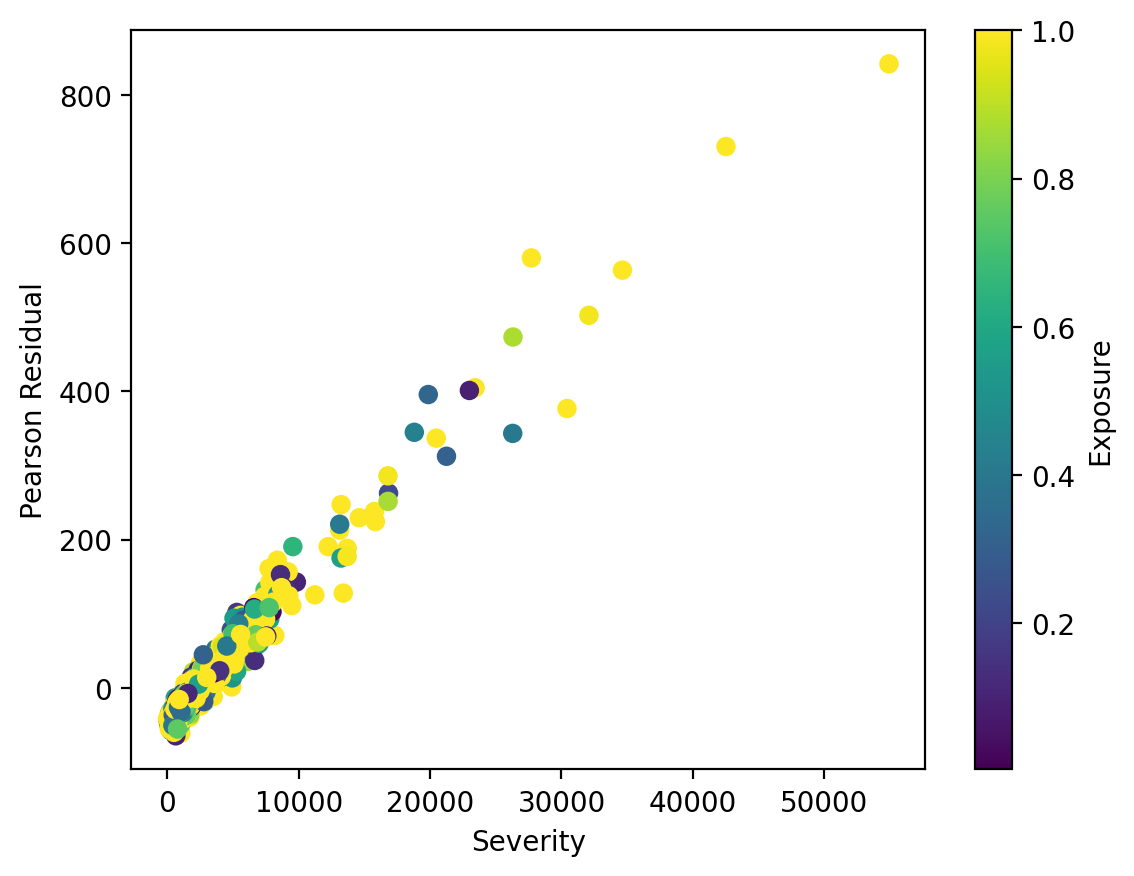

In [17]:
y_resid = y_train - y_pred
pearsonResid = np.where(y_pred > 0.0, y_resid / np.sqrt(y_pred), np.NaN)
plt.figure(dpi = 200)
sg = plt.scatter(y_train, pearsonResid, c = train_data_copy['EXPOSURE'], marker = 'o',cmap="viridis")
plt.xlabel('Severity')
plt.ylabel('Pearson Residual')
plt.xticks(range(0,round(train_data["SEVERITY"].max()),10000))
plt.grid(axis = 'both')
plt.colorbar(sg, label = 'Exposure')
plt.grid()
plt.show()

<b>b) (10 points). Plot the Deviance residuals versus the observed Severity.

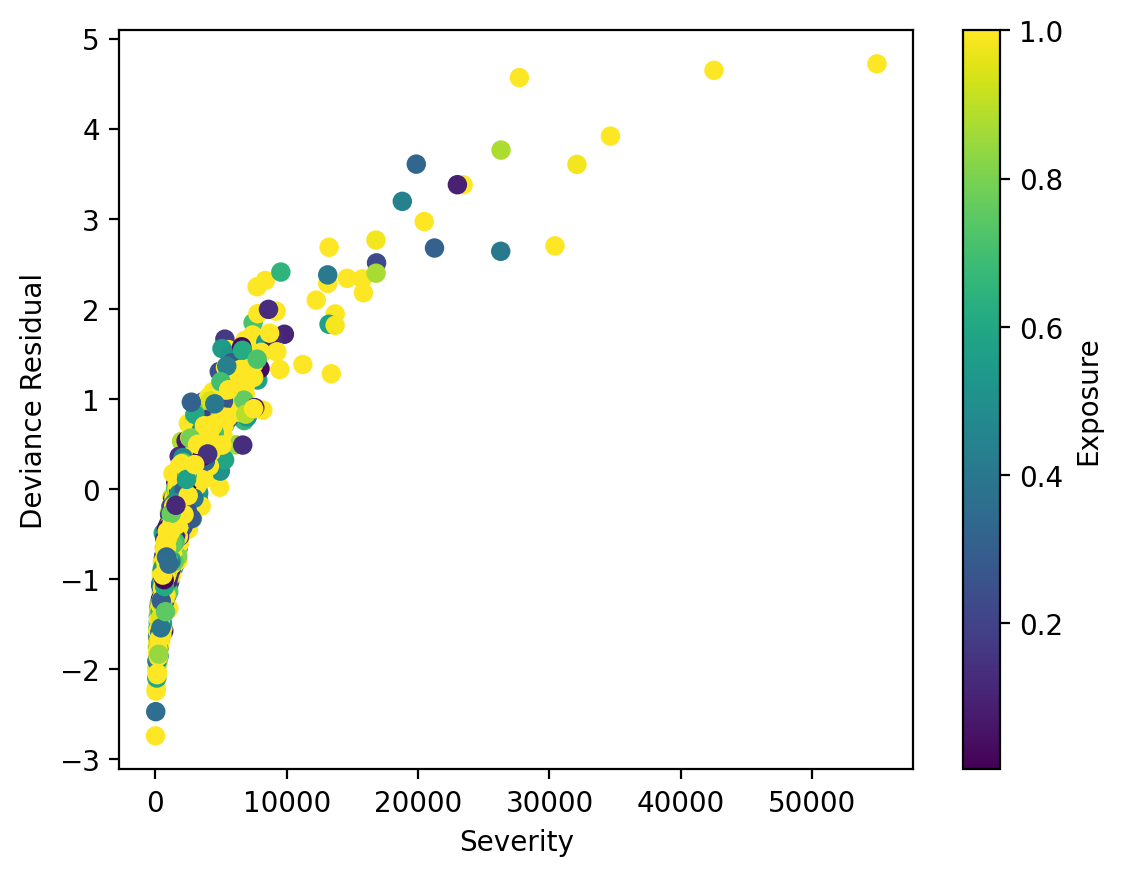

In [18]:
plt.figure(dpi = 200)
sg = plt.scatter(y_train, devResid, c = train_data_copy['EXPOSURE'], marker = 'o',cmap ="viridis")
plt.xlabel('Severity')
plt.ylabel('Deviance Residual')
plt.xticks(range(0,round(train_data["SEVERITY"].max()),10000))
plt.grid(axis = 'both')
plt.colorbar(sg, label = 'Exposure')
plt.grid()
plt.show()